# Big Data Management and Analysis in Physics Research
# Claudio Fadda (813499)

## Esercizio serie storica
Questo secondo esercizio richiede di effettuare un'analisi di dati di serie storica.

Leggendo il dataset `data/globaltemperatures.csv`, caricare i dati della media della temperatura nei diversi mesi dell'anno dal 1750. Plottare la serie dati, analizarne le caratteristiche (tendenza e stagionalità) e provare a fare una regressione lineare del trend (per valutarne la tendenza). Per fare regressione lineare di una timeseries è conveniente trasformare l'indice (l'asse X) in un numero che indica il numero di periodi passati dal momento inziale.

Infine provare a usare la serie storica per produrre le temperature dei successivi 10 anni.

In [67]:
# impostiamo la data come indice e la parsiamo nel modo corretto
import pandas as pd

df = pd.read_csv('data/globaltemperatures.csv', parse_dates=['dt'], index_col='dt')
df

,LandAverageTemperature,LandAverageTemperatureUncertainty
dt,,
1750-01-01,3.034,3.574
1750-02-01,3.083,3.702
1750-03-01,5.626,3.076
1750-04-01,8.490,2.451
1750-05-01,11.573,2.072
...,...,...
2015-08-01,14.755,0.072
2015-09-01,12.999,0.079
2015-10-01,10.801,0.102


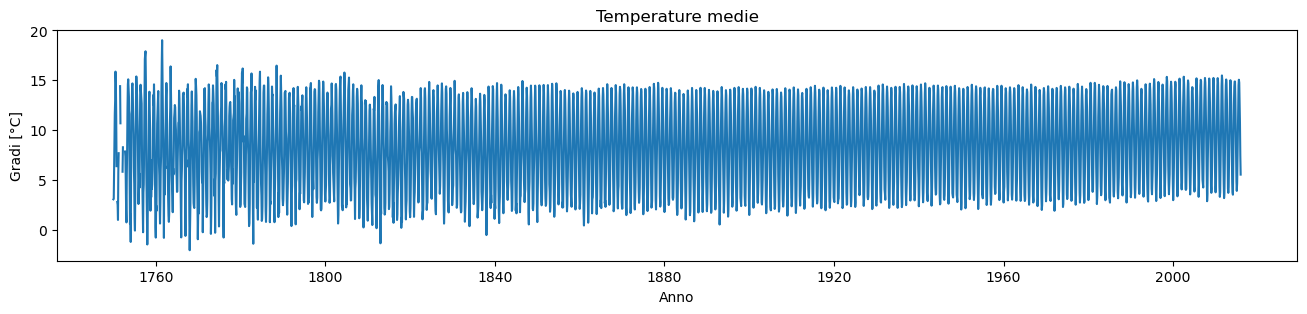

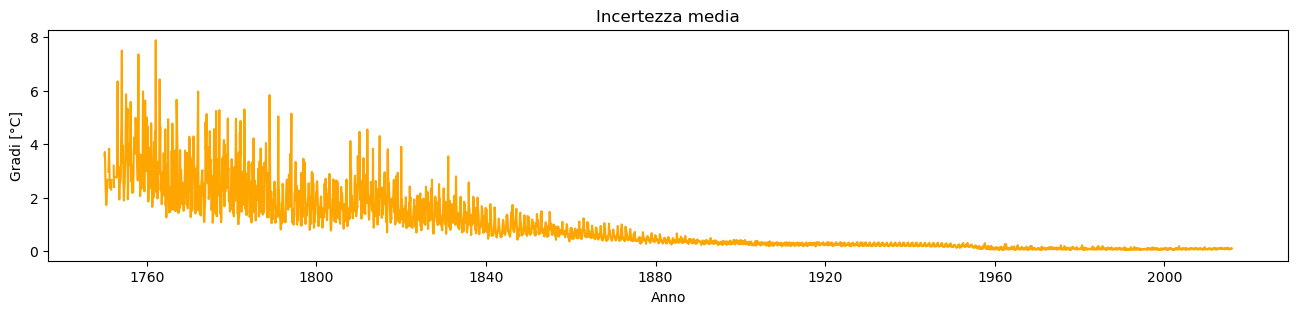

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,3))
plt.plot(df.index, df.LandAverageTemperature)
plt.title('Temperature medie')
plt.xlabel('Anno')
plt.ylabel('Gradi [°C]')
plt.show()

plt.figure(figsize=(16,3))
plt.plot(df.index, df.LandAverageTemperatureUncertainty, color="orange")
plt.title('Incertezza media')
plt.xlabel('Anno')
plt.ylabel('Gradi [°C]')
plt.show()

Per quanto riguarda le temperature mensili:
- si nota una variabilità più alta all'inizio della serie (probabilmente i primi sono dati storici);
- si notano dei buchi nella serie relativi ai dati mancanti.

Per quanto riguarda il grafico delle incertezze:
- si nota che l'incertezza diminuisce man mano che ci si avvicina al presente.

### Valori mancanti

In [69]:
na1 = df.LandAverageTemperature.isnull().sum()
na2 = df.LandAverageTemperatureUncertainty.isnull().sum()
print("Valori mancanti totali: %d " % (na1))
print("Valori mancanti totali: %d " % (na2))

Valori mancanti totali: 12 
Valori mancanti totali: 12 


In [70]:
dfi = df.copy()
dfi.drop('LandAverageTemperatureUncertainty', inplace=True, axis=1)

In [71]:
dfi.interpolate(method='spline', order=4,
                      axis=0, 
                      limit=None, 
                      inplace=True)

In [72]:
dfi["withNan"] = df["LandAverageTemperature"]

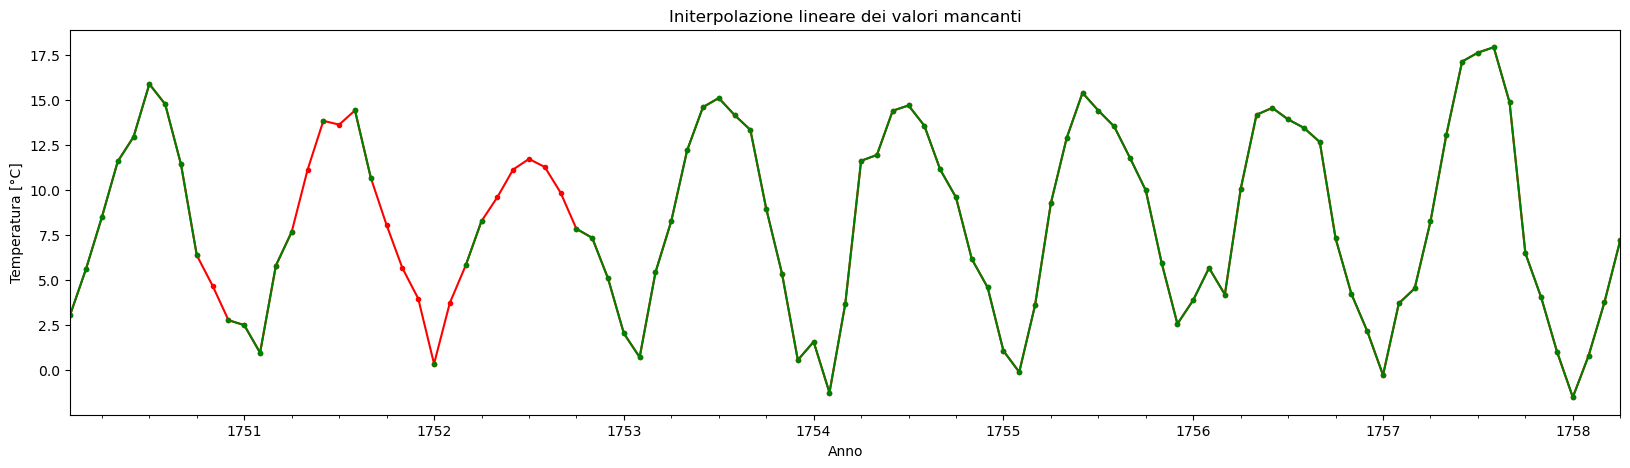

In [73]:
dfi['LandAverageTemperature'][1:100].plot(title='Actual', label='Actual', color='red', style=".-")
dfi['withNan'][1:100].plot(color='green', label='Cubic Fill', style=".-")
plt.title("Initerpolazione lineare dei valori mancanti")
plt.xlabel("Anno")
plt.ylabel("Temperatura [°C]")
plt.show()

In [74]:
df["LandAverageTemperature"] = dfi["LandAverageTemperature"]

### Analisi della serie storica

C:\Users\fadda\anaconda3\envs\prophet\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


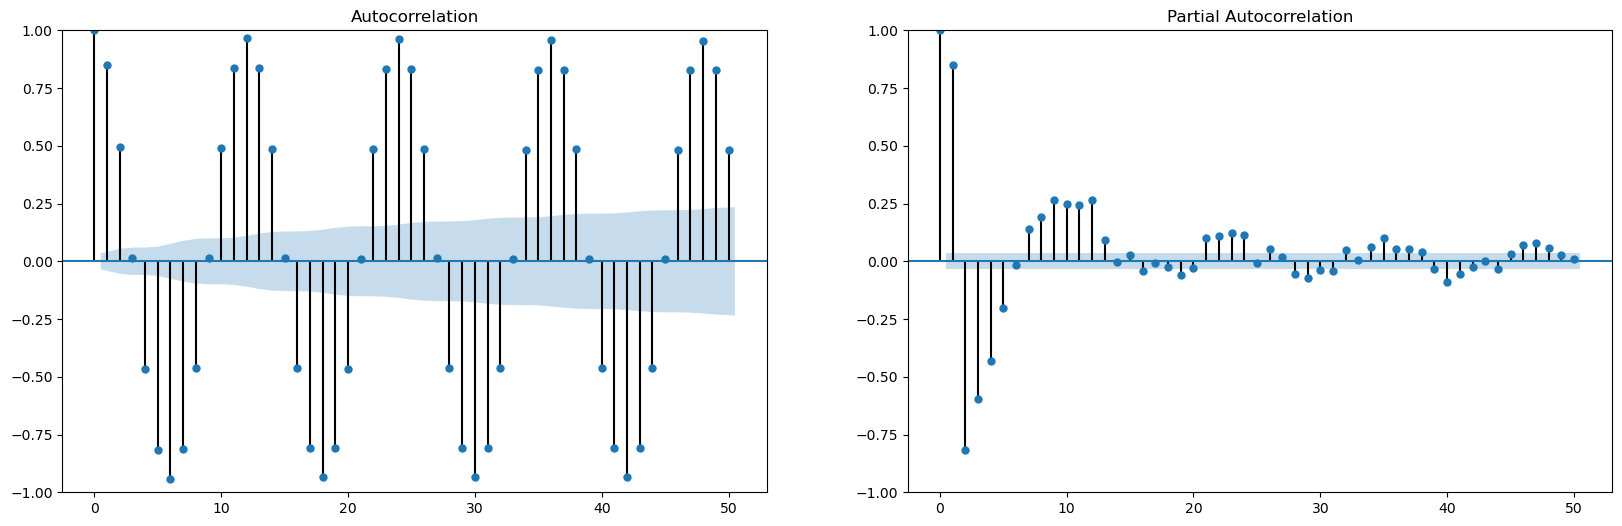

In [75]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(20,6))
plot_acf(df.LandAverageTemperature.tolist(), lags=50, ax=axes[0])
plot_pacf(df.LandAverageTemperature.tolist(), lags=50, ax=axes[1])
plt.show()

Dall'ACF possiamo notare come abbiamo dei massimi e dei minimi oni 6 lag, questo ovviamente rispecchia l'andamento delle temperature durante tutti gli anni della serie e ci suggerisce la presenza di una stagionalità semestrale.
Allo stesso modo nel PACF possiamo notare come ogni 6 lag le bande escano fuori dall'intervallo di confidenza.

Verifichiamo che sia stazionaria con il test di Dickey-Fuller:

In [76]:
from statsmodels.tsa.stattools import adfuller

X = df.LandAverageTemperature
result = adfuller(X)

In [77]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.872460
p-value: 0.002247
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Per quanto riguarda il Test sia il p-value che la statistica test ci permette di rifiutare l'ipotesi nulla, e quindi dire che la serie sia stazionaria.

#### Scomposizione

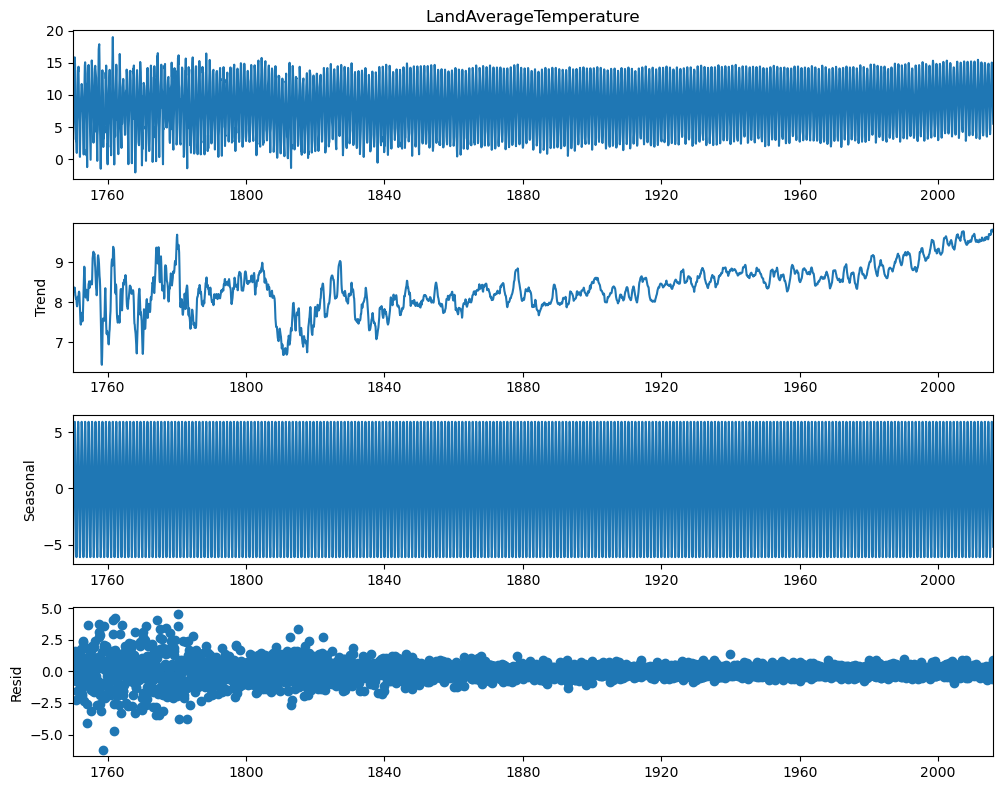

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


result_add = seasonal_decompose(df['LandAverageTemperature'], model='additive', extrapolate_trend='freq') #scomposiziona additiva


plt.rcParams.update({'figure.figsize': (10, 8)})
result_add.plot()
plt.show()

Dall'analisi della scomposizione possiamo notare come a differenza del test di Dickey-Fuller, la serie non sia pienamente stazionaria:
- Trend: il trend a parte quello iniziale che soffre di tanta incertezza (per la storia del dato), alla fine sale e quindi posiamo vedere come non ha una media nulla.
- Stagionalità: per la troppa presenza di dati non è facilmente intuibile;
- Residui: i residui sono abbastanza buoni alla fine della serie, centrati verso lo 0; inizialmente invece notiamo che è presnte della irregolarità.

### Andiamo ad estrarre il trend della serie per svolgere una regressione lineare

Text(0, 0.5, 'Temperatura [°C]')

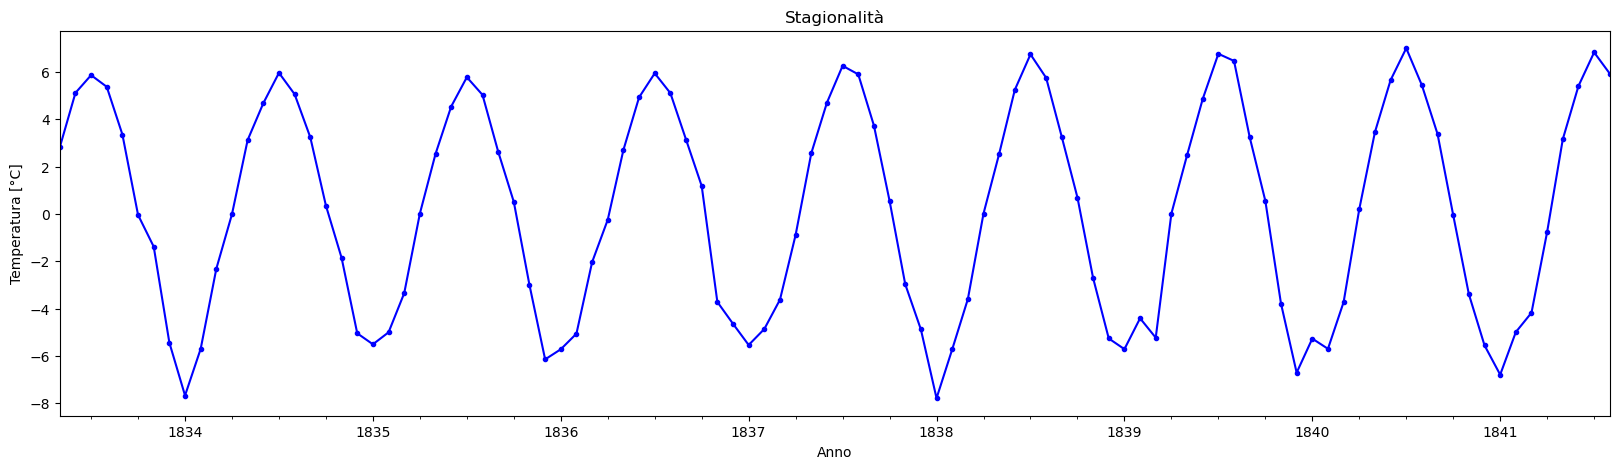

In [79]:
# eliminiamo quindi il trend

from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df['LandAverageTemperature'], model='additive', extrapolate_trend='freq')
deseasonalized = df['LandAverageTemperature'].values - result_mul.trend

plt.rcParams.update({'figure.figsize': (20, 5)})
deseasonalized[1000:1100].plot(color='blue', label='Cubic Fill', style=".-")
plt.title("Stagionalità")
plt.xlabel("Anno")
plt.ylabel("Temperatura [°C]")

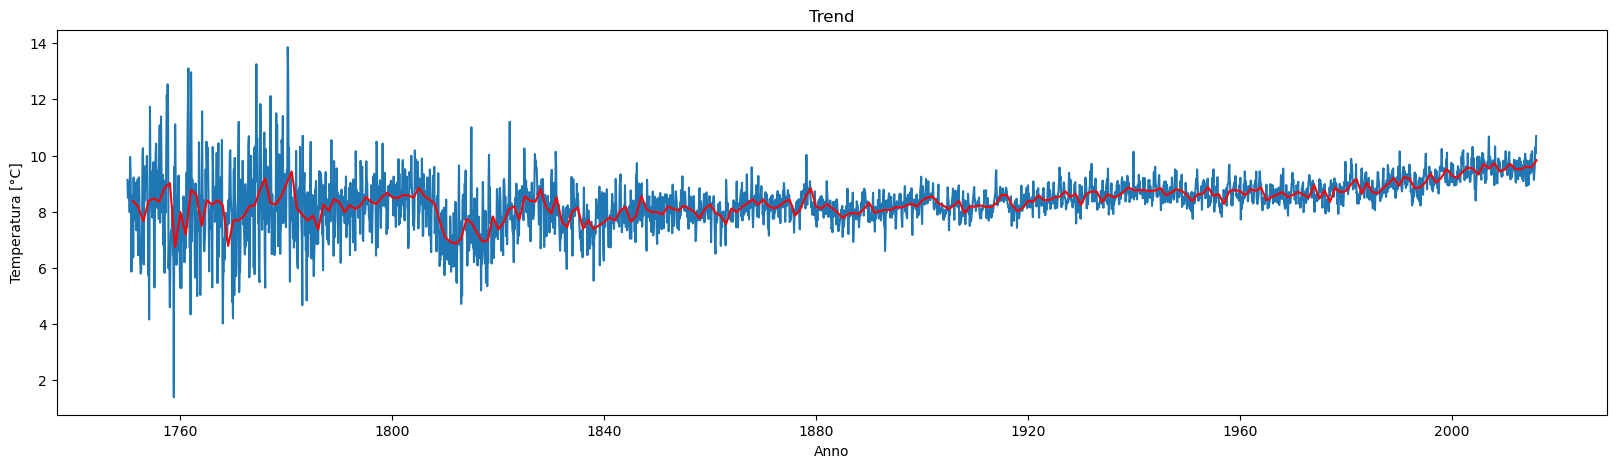

In [80]:
# eliminiamo quindi la stagionalità

from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df['LandAverageTemperature'], model='additive', extrapolate_trend='freq')
deseasonalized = df['LandAverageTemperature'].values - result_mul.seasonal


plt.rcParams.update({'figure.figsize': (20, 5)})
plt.plot(df.index, deseasonalized)
plt.plot(deseasonalized.resample("Y").mean(), color="red", label = "Annual averages")
plt.title("Trend")
plt.xlabel("Anno")
plt.ylabel("Temperatura [°C]")
plt.show()


In [81]:
df2 = deseasonalized.to_frame()

In [82]:
df2.reset_index(inplace = True)

In [83]:
df2.rename(columns={'seasonal':'trend'}, inplace = True)

### Regressione lineare

In [84]:
df2.reset_index(inplace=True)

In [85]:
df2.rename(columns={'index':'periodo'}, inplace = True)

In [86]:
dfrr = df.copy()

In [87]:
dfrr.reset_index(inplace=True)

In [88]:
df2["LandAverageTemperatureUncertainty"] = dfrr["LandAverageTemperatureUncertainty"]

In [89]:
df2

,periodo,dt,trend,LandAverageTemperatureUncertainty
0,0,1750-01-01,9.132196,3.574
1,1,1750-02-01,8.491760,3.702
2,2,1750-03-01,9.042455,3.076
3,3,1750-04-01,8.615481,2.451
4,4,1750-05-01,8.801220,2.072
...,...,...,...,...
3187,3187,2015-08-01,9.381393,0.072
3188,3188,2015-09-01,9.660444,0.079
3189,3189,2015-10-01,10.297117,0.102
3190,3190,2015-11-01,10.073100,0.119


In [90]:
import statsmodels.api as sm
X = sm.add_constant(df2["periodo"])

In [91]:
model = sm.OLS(df2['trend'],X)
results = model.fit()
results.params

const      7.766188
periodo    0.000382
dtype: float64

In [92]:
y_pred_train = results.predict(X)


In [93]:
yhat = df2.index * results.params['periodo'] + results.params['const']

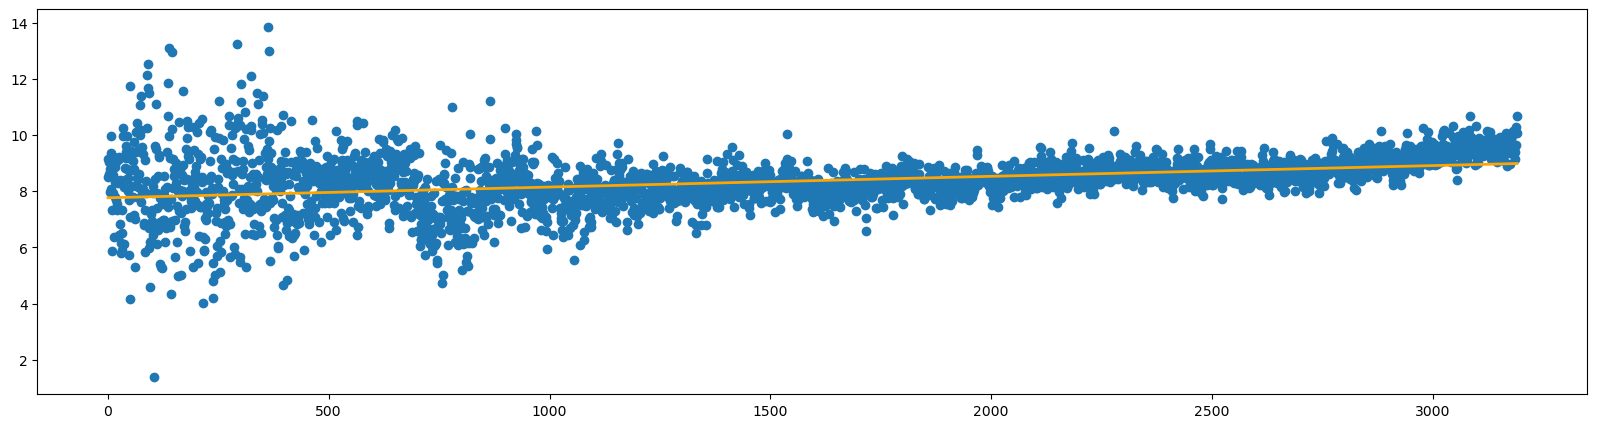

In [94]:
plt.scatter(df2.periodo, df2.trend)
fig = plt.plot(X['periodo'], yhat, lw=2, c='orange') #ols generalizzato

Vediamo come la regressione lineare tracciata sembra seguire abbastanza bene i dati, con meno costanza alla fine della serie storica (quando il trend è in aumento).

## WLS (Weighted least squares)

Fa uso dei pesi, quindi andremmo a calcolare questi attraverso la colonna "LandAverageTemperatureUncertainty" che rappresenta lo standard error dei nostri dati. Un peso maggiore (importanza più alta) viene dato ai dati con standard error minore, mentre un peso minore viene assegnato a quei dati che sono meno precisi.

In [95]:
# calcolo i pesi secondo la documentazione di wls da statsmodels
weights= 1.0 / (df["LandAverageTemperatureUncertainty"] ** 2)

In [101]:
c = weights.to_frame()
df3 = weights.to_frame().reset_index()
r = df.copy()
r.reset_index(inplace = True)
df3["LandAverageTemperature"] = df2["trend"]
df3= df3.rename(columns={'LandAverageTemperature': 'trend'})

In [102]:
df3.isnull().sum()

dt                                    0
LandAverageTemperatureUncertainty    12
trend                                 0
dtype: int64

In [104]:
df4 = df3.copy()
df4.dropna(inplace= True)

In [105]:
x = sm.add_constant(df4.LandAverageTemperatureUncertainty)
df4.reset_index(inplace = True)
c = df4.index
C = sm.add_constant(c)

In [107]:
mod_wls = sm.WLS(df4["trend"], C, weights=df4["LandAverageTemperatureUncertainty"])

res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                  trend   R-squared:                       0.413
Model:                            WLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     2240.
Date:                Thu, 26 Jan 2023   Prob (F-statistic):               0.00
Time:                        09:51:08   Log-Likelihood:                -5217.7
No. Observations:                3180   AIC:                         1.044e+04
Df Residuals:                    3178   BIC:                         1.045e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3193      0.057    111.083      0.0

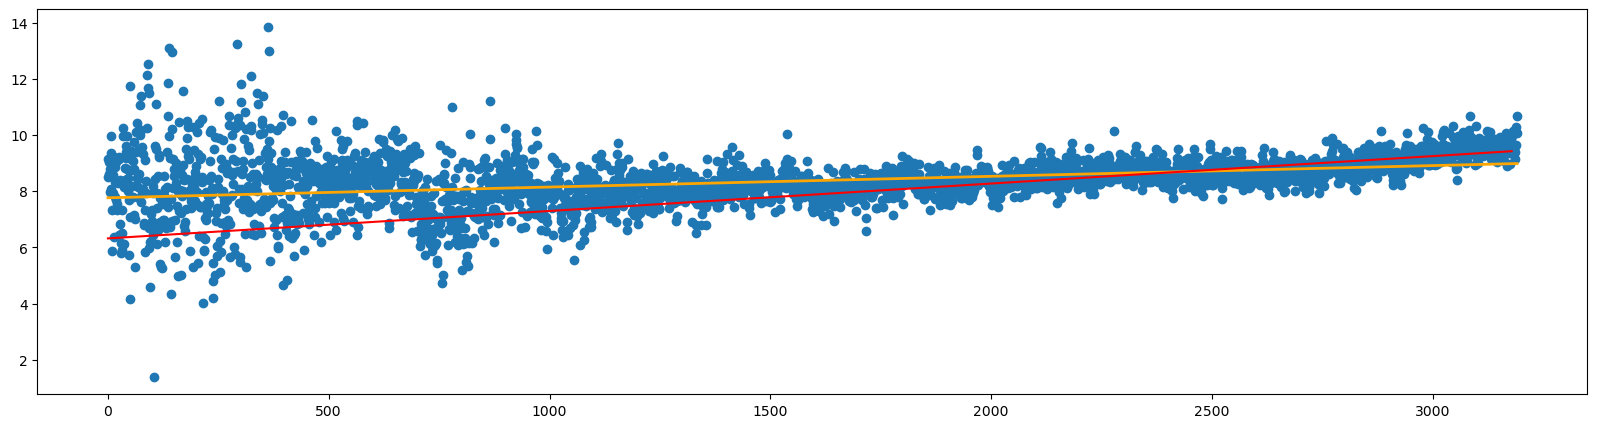

In [108]:
plt.scatter(df2.periodo, df2.trend)
fig = plt.plot(df2.index, yhat, lw=2, c='orange') #ols generalizzato
plt.plot(df4.index, res_wls.predict(C), c='red')

La retta arancione ci mostra una regressione lineare del trend tramite gli OLS, mentre la retta rossa ci mostra una regressione lineare svolta tramite il metodo WLS; si nota come la pendenza della retta rossa sia maggiore di quella arancione.

## Forecast 10 anni in avanti

In [131]:
dfo = df.copy()
dfo.drop('LandAverageTemperatureUncertainty', inplace=True, axis=1)


In [132]:
future = dfo[-36:]
past = dfo[:-36]

Diamo come valori massimi di p (ordine del processo autoregressivo) e q (ordine del processo a media mobile).

In [133]:
import pmdarima as pm

smodel = pm.auto_arima(past, start_p=1, start_q=1,
                       max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=11.48 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=9373.761, Time=0.33 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8264.108, Time=3.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=6.44 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=9371.821, Time=0.34 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=9076.189, Time=0.65 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=8022.815, Time=6.75 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=38.31 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=12.52 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=8362.556, Time=4.97 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=8018.402, Time=9.20 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=8260.869, Time=4.71 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=26.34 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=14.50 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=8

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 3168
Model:             SARIMAX(3, 0, 3)x(2, 1, [], 12)   Log Likelihood               -3966.515
Date:                             Wed, 25 Jan 2023   AIC                           7951.030
Time:                                     19:22:21   BIC                           8005.544
Sample:                                 01-01-1750   HQIC                          7970.588
                                      - 12-01-2013                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1733      0.026     82.271      0.000       2.122       2.225
ar.L2         -1.8680      0.043    -43.294      0.000      -1.953      -1.783
ar.L3          0.5391      0.026     20.680      0.000       0.488       0.590
ma.L1         -1.8843      0.031    -60.785      0.000      -1.945      -1.824
ma.L2          1.3684      0.051     26.941      0.000       1.269       1.468
ma.L3         -0.2347      0.030     -7.701      0.000      -0.294      -0.175
ar.S.L12      -0.5978      0.010    -60.800      0.000      -0.617      -0.578
ar.S.L24      -0.2602      0.009    -28.528      0.000      -0.278      -0.242
sigma2         0.7221      0.009     79.879      0.000       0.704       0.740
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5549.36
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

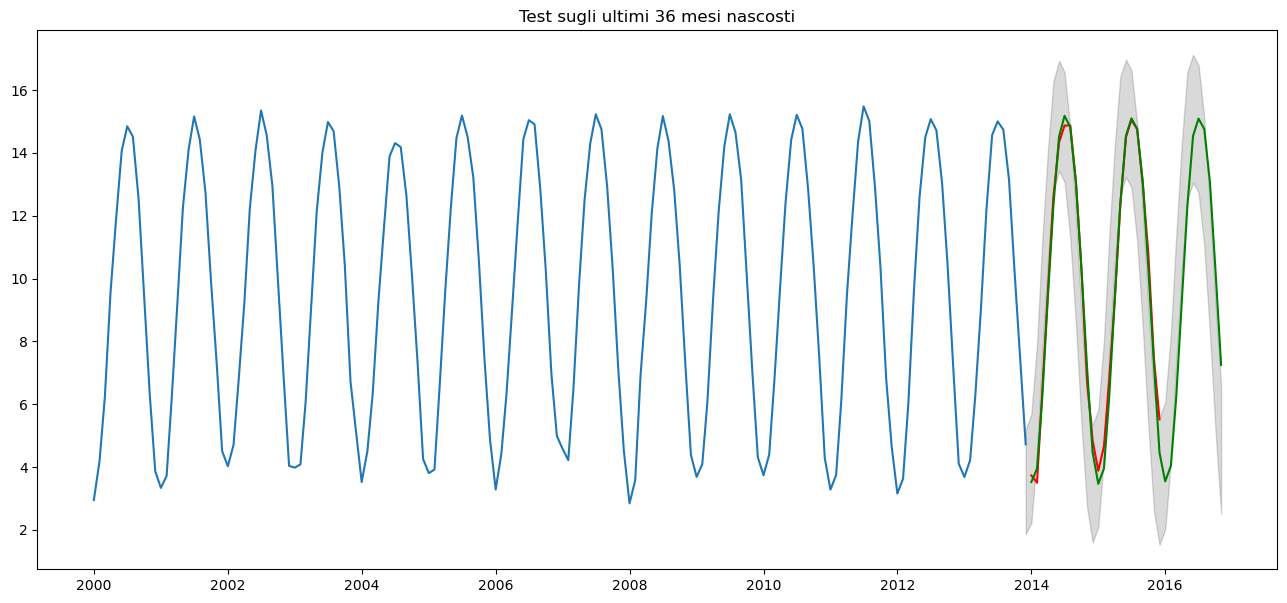

In [151]:
# Forecast
n_periods = 36
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(past.index[-1], periods=n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(past[3000:])
plt.plot(future, color='red')

plt.plot(fitted_series, color='green')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Test sugli ultimi 36 mesi nascosti")
plt.show()

Vediamo che le predizioni sul test sono buone, la curva verde (predizione) è molto vicina alla curva rossa (valori nascosti al training).

Facciamo ora il forecast per i prossimi dieci anni, a partire dall'ultimo valore della serie storica originale.

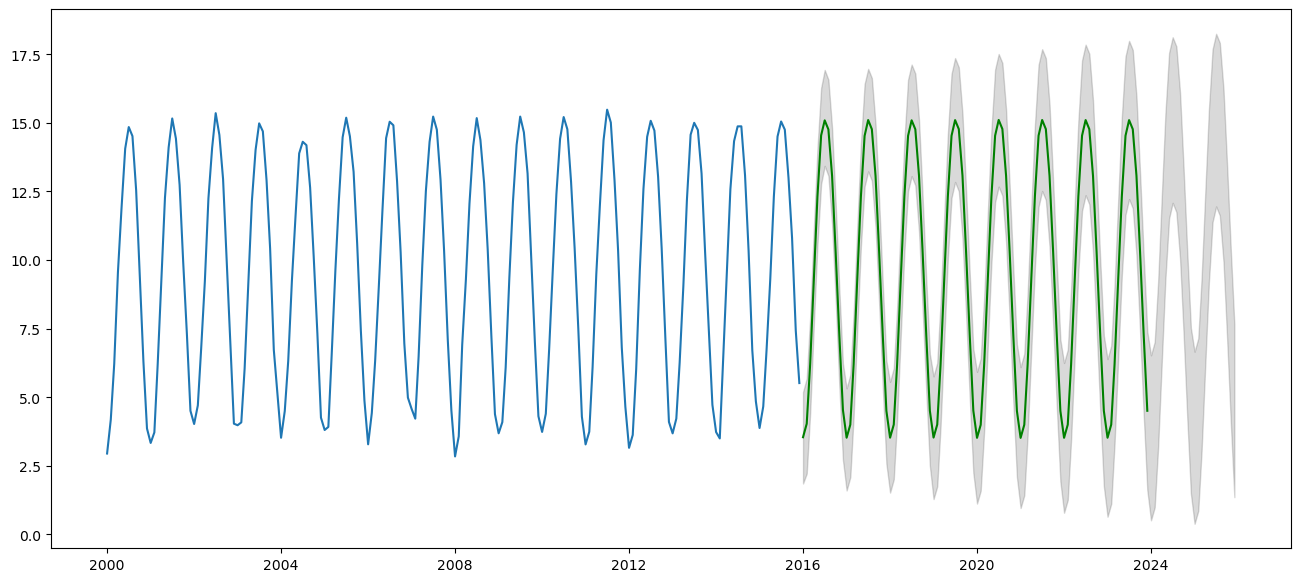

In [154]:
# Forecast
n_periods = 120
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods=n_periods+1, freq='MS')[1:]

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))
plt.plot(dfo["LandAverageTemperature"][3000:])
plt.plot(fitted_series, color='green')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.show()

Anche il forecast 10 anni in avanti è buono, da notare come le bande di confidenza man mano che si va verso il futuro si espandano maggiormente.

### Prophet

In [155]:
dfp = df.copy()
dfp

,LandAverageTemperature,LandAverageTemperatureUncertainty
dt,,
1750-01-01,3.034,3.574
1750-02-01,3.083,3.702
1750-03-01,5.626,3.076
1750-04-01,8.490,2.451
1750-05-01,11.573,2.072
...,...,...
2015-08-01,14.755,0.072
2015-09-01,12.999,0.079
2015-10-01,10.801,0.102


In [156]:
dfp= dfp.reset_index().rename(columns={'dt': 'ds', 'LandAverageTemperature': 'y'})

In [157]:
from fbprophet import Prophet
import matplotlib.pyplot as plt

model = Prophet(seasonality_mode='additive')
model.fit(dfp) 

C:\Users\fadda\anaconda3\envs\prophet\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\fadda\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


C:\Users\fadda\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\fadda\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


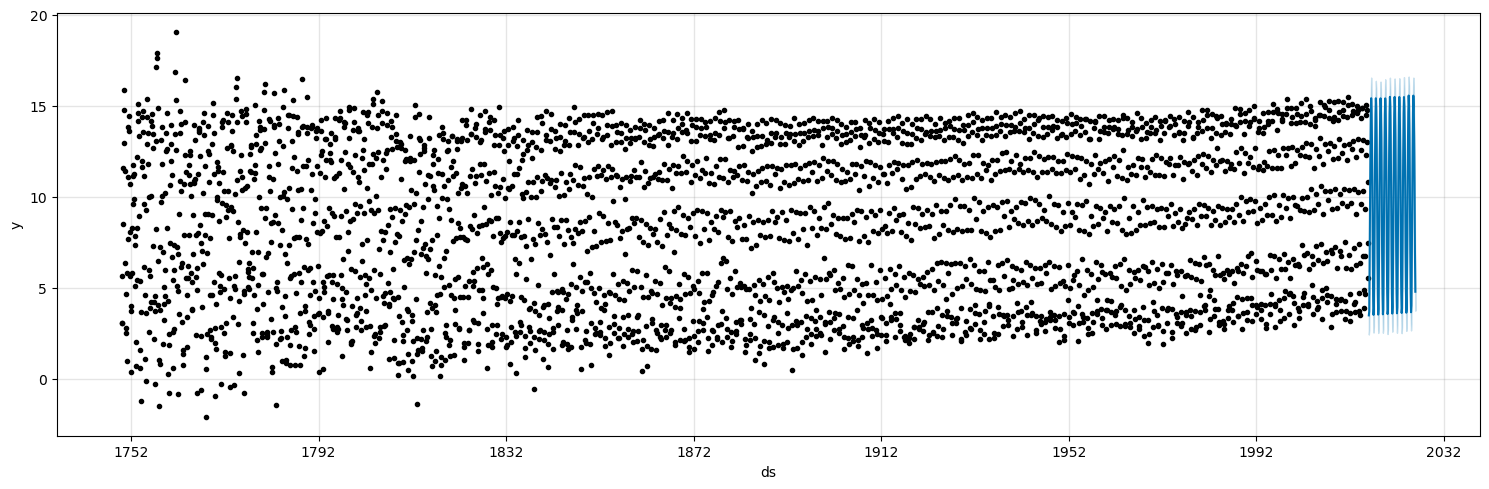

In [163]:
n_periods = 120
future = pd.DataFrame()
future['ds'] = pd.date_range(start=df.index.max(), periods=n_periods, freq="M")
df_fcst = model.predict(df=future)

f, ax = plt.subplots(1, 1, figsize=(15, 5))
fig = model.plot(df_fcst, ax=ax)
plt.show()

Questa è la predizione 10 anni in avanti attravero un modello prophet, da notare come sembra che venga mantenuto un trend crescente in linea con la serie storica originale.

C:\Users\fadda\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


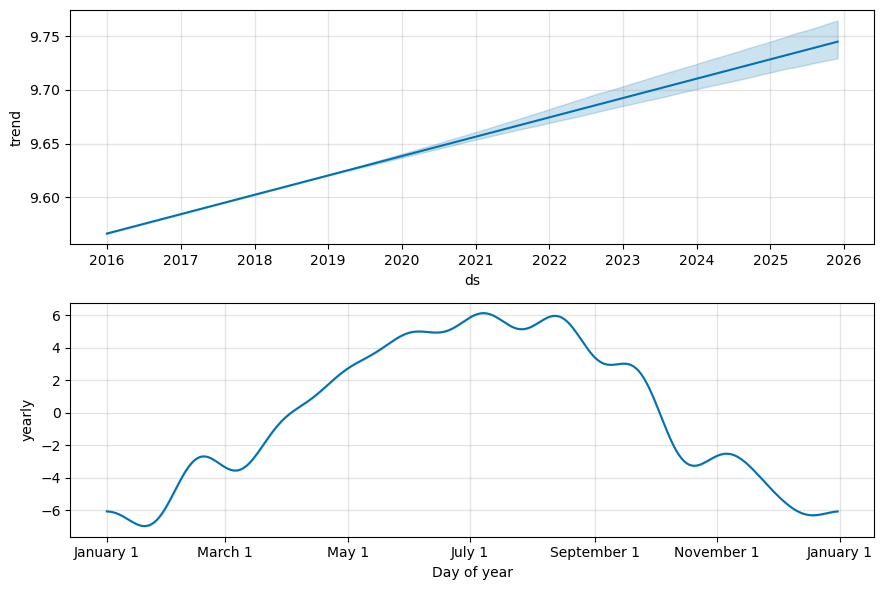

In [56]:
fig2 = model.plot_components(df_fcst)